In [1]:
##################>>>> import attacks generation methods
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import BoundaryAttack
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import CarliniLInfMethod
from art.attacks.evasion import DeepFool
from art.attacks.evasion import ElasticNet
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import HopSkipJump
from art.attacks.evasion import NewtonFool
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import SaliencyMapMethod
from art.attacks.evasion import TargetedUniversalPerturbation
from art.attacks.evasion import UniversalPerturbation 
from art.attacks.evasion import VirtualAdversarialMethod
from art.attacks.evasion import ZooAttack
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist
from datetime import date
from datetime import datetime
from keras.layers import Dense
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
from numpy.random import seed #===========> under it: seed(1)
seed(1) 
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.preprocessing import MinMaxScaler # used for feature scaling
from sklearn.preprocessing import RobustScaler # used for feature scaling
from sklearn.preprocessing import StandardScaler # used for feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler # used for feature scaling
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import csv
import glob
import io
import keras
import matplotlib.pyplot as plt
import numpy as np # used for handling numbers
import os
import pandas as pd # used for handling the dataset
import requests
import seaborn as sns
import tensorflow #===========> under it: tensorflow.random.set_seed(2)
tensorflow.random.set_seed(2)
import tensorflow as tf #=============> under it: tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_eager_execution()
import timeit
import seaborn as sns
import itertools
#====================================================>

In [4]:
#==============================> Splitting Datasets into training and testing
dataset_name='WSN-DS'
###############################
training_dataset=pd.read_csv("Input/Datasets/WSNDS-training-5Class.csv", sep=',', low_memory=False)
training_dataset.columns = [*training_dataset.columns[:-1], 'Class']
################################
X_train=training_dataset.iloc[:, 0:16]
#y_train=training_dataset.iloc[:,[43]]
y_train=training_dataset.iloc[ :, -1:]
################################
testing_dataset=pd.read_csv("Input/Datasets/WSNDS-testing-5Class.csv", sep=',', low_memory=False)
testing_dataset.columns = [*testing_dataset.columns[:-1], 'Class']
#===============================> Converting to Dataframes
X_test=testing_dataset.iloc[:, 0:16]
#y_train=training_dataset.iloc[:,[43]]
y_test=testing_dataset.iloc[ :, -1:]
#===============================> Transforming datasets
X_num_col=[col for col in X_train.columns if X_train[col].dtype!='O']
X_cat_col=[col for col in X_train.columns if X_train[col].dtype=='O']
X_columnTransformer=ColumnTransformer([('ScalingStep', MinMaxScaler(), X_num_col),('OneHotEncodingStep', OneHotEncoder(sparse=False, handle_unknown='ignore'), X_cat_col)], remainder="passthrough")
X_columnTransformer.fit(X_train)
#--------
X_train=pd.DataFrame(X_columnTransformer.transform(X_train))
X_test=pd.DataFrame(X_columnTransformer.transform(X_test))
#----------
y_train=pd.get_dummies(y_train)
y_test=pd.get_dummies(y_test)
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
#=============================================== Saving the datasets
X_train.to_csv("Input/Datasets/X_train-WSN-5Class.csv", index=False, header=True)
X_test.to_csv("Input/Datasets/X_test-WSN-5Class.csv", index=False, header=True)
#===============================================
pd.DataFrame(y_train).to_csv("Input/Datasets/y_train-WSN-5Class.csv", index=False, header=True)
pd.DataFrame(y_test).to_csv("Input/Datasets/y_test-WSN-5Class.csv", index=False, header=True)
#===============================================

In [ ]:
####################### Building the attacked model
model_to_attack = Sequential()
model_to_attack.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model_to_attack.add(Dropout(0.2)) #to prevent overfitting
model_to_attack.add(Dense(64, activation='relu'))
model_to_attack.add(Dropout(0.2)) #to prevent overfitting
model_to_attack.add(Dense(32, activation='relu'))
model_to_attack.add(Dropout(0.2)) #to prevent overfitting
model_to_attack.add(Dense(y_train.shape[1],activation='softmax'))
model_to_attack.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_to_attack.fit(X_train, y_train, batch_size=64, epochs=100)
KerasClassifier_to_attack=KerasClassifier(model=model_to_attack, use_logits=False)
model_to_attack.save("Output/trainedmodel-WSNDS-MultiClassifier.h5")
#==========================================================

In [2]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Set3):
                        #cmap=plt.cm.Blues
                        #cmap=plt.cm.gist_rainbow
                        #cmap=plt.cm.nipy_spectral
                        #cmap=plt.cm.hsv
                        #plt.cm.paired
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(x,y))
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("Output/Confusion Matrix Charts/"+title+'.png', dpi=1300, transparent=True)

In [7]:
X_test_attack=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
y_test_attack=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
X_test_normal=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)
y_test_normal=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)

In [3]:
model_to_attack=load_model("Output/trainedmodel-WSNDS-MultiClassifier.h5")
KerasClassifier_to_attack=KerasClassifier(model=model_to_attack, use_logits=False)

In [3]:
############################################################################################
def generate_adv_evasion(KerasClassifier_to_attack, _attack, _setup, _targeted):
	X_test_attack=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
	y_test_attack=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
	X_test_normal=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)
	y_test_normal=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)
	#########################################################################################
	y_test_attack=y_test_attack.to_numpy()
	y_test_normal=y_test_normal.to_numpy()
	########################################################################################
	today = date.today().strftime("%b-%d-%Y")
	current_time = datetime.now().strftime("%H:%M:%S")
	if _targeted==True:
			_targeted_tex='Targeted'
	elif _targeted==False:
			_targeted_tex='Untargeted'
	else:
			_targeted_tex=''
	adv_ex_name="Output/Crafted Testing Data/"+_attack+'['+_targeted_tex+']X-test.csv'
	dataset='WSN-DS'
	if dataset=='WSN-DS':
			labels=['Blackhole', 'Flooding', 'Grayhole', 'Normal', 'TDMA']
			no_attacks_records= 8649
	################################################################################################
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	progressLine='{} @ {} ---> {} attack [{}] will be executed on the testing dataset'.format(today, current_time, _attack, _targeted_tex)
	print(progressLine)
	progross_file = open("Output/progress.txt","a")
	progross_file.writelines("\n")
	progross_file.writelines(progressLine)
	progross_file.writelines("\n")
	progross_file.close()
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	#################################################################################################
	if _attack=='CarliniL2Method': 
		CarliniL2Method_Attack=CarliniL2Method(classifier=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=CarliniL2Method_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False) 
	elif _attack=='CarliniLInfMethod': 
		CarliniLInfMethod_Attack=CarliniLInfMethod(classifier=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=CarliniLInfMethod_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='DeepFool': 
		DeepFool_Attack=DeepFool(classifier=KerasClassifier_to_attack)
		starttime=timeit.default_timer()
		adv_ex=DeepFool_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='ElasticNet': 
		ElasticNet_Attack=ElasticNet(classifier=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=ElasticNet_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='FastGradientMethod': 
		FastGradientMethod_Attack=FastGradientMethod(estimator=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=FastGradientMethod_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='BasicIterativeMethod': 
		BasicIterativeMethod_Attack=BasicIterativeMethod(estimator=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=BasicIterativeMethod_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='ProjectedGradientDescent': 
		ProjectedGradientDescent_Attack=ProjectedGradientDescent(estimator=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=ProjectedGradientDescent_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='NewtonFool': 
		NewtonFool_Attack=NewtonFool(classifier=KerasClassifier_to_attack)
		starttime=timeit.default_timer()
		adv_ex=NewtonFool_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='SaliencyMapMethod': 
		SaliencyMapMethod_Attack=SaliencyMapMethod(classifier=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=SaliencyMapMethod_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='TargetedUniversalPerturbation-deepfool': 
		#TargetedUniversalPerturbation_Attack=TargetedUniversalPerturbation(classifier=KerasClassifier_to_attack, targeted=_targeted)
		TargetedUniversalPerturbation_Attack=TargetedUniversalPerturbation(classifier=KerasClassifier_to_attack)
		starttime=timeit.default_timer()
		adv_ex=TargetedUniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='TargetedUniversalPerturbation-fgsm': 
		TargetedUniversalPerturbation_Attack=TargetedUniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='fgsm')
		starttime=timeit.default_timer()
		adv_ex=TargetedUniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
		#################################################
	elif _attack=='UniversalPerturbation-fgsm':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='fgsm')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-carlini_inf':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='carlini_inf')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-bim':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='bim')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-deepfool':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='deepfool')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-newtonfool':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='newtonfool')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-carlini':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='carlini')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-pgd':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='pgd')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='UniversalPerturbation-jsma':
		UniversalPerturbation_Attack=UniversalPerturbation(classifier=KerasClassifier_to_attack, attacker='jsma')
		starttime=timeit.default_timer()
		adv_ex=UniversalPerturbation_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	###################################
	elif _attack=='VirtualAdversarialMethod': 
		VirtualAdversarialMethod_Attack=VirtualAdversarialMethod(classifier=KerasClassifier_to_attack)
		starttime=timeit.default_timer()
		adv_ex=VirtualAdversarialMethod_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='BoundaryAttack': 
		BoundaryAttack_Attack=BoundaryAttack(estimator=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=BoundaryAttack_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='HopSkipJump': 
		HopSkipJump_Attack=HopSkipJump(classifier=KerasClassifier_to_attack, targeted=_targeted)
		starttime=timeit.default_timer()
		adv_ex=HopSkipJump_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='ZooAttack': 
		ZooAttack_Attack=ZooAttack(classifier=KerasClassifier_to_attack, nb_parallel=15)
		starttime=timeit.default_timer()
		adv_ex=ZooAttack_Attack.generate(x=X_test_attack, y=y_test_attack)
		time_difference= timeit.default_timer()- starttime
		adv_ex_df = pd.DataFrame(adv_ex)
		adv_ex_df.to_csv(adv_ex_name, index=False)
	elif _attack=='No Attack':
		adv_ex_df=X_test_attack
		starttime=timeit.default_timer()
		time_difference= timeit.default_timer()- starttime
	####################################################
	with open("Output/Performance Evaluation/EvasionModelExcutionMulticlassification.csv", mode='a', newline='') as resultsFile:
		results_writer = csv.writer(resultsFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL,lineterminator='\r')
		results_writer.writerow([ _attack,  _setup, _targeted_tex, dataset, today, current_time, starttime, time_difference])
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	progressLine='{} @ {} ---> {} attack [{}] was done on the testing datset'.format(today, current_time, _attack, _targeted_tex)
	print(progressLine)
	progross_file = open("Output/progress.txt","a")
	progross_file.writelines("\n")
	progross_file.writelines(progressLine)
	progross_file.writelines("\n")
	progross_file.writelines("==============================================================================")
	progross_file.close()
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	

In [ ]:
#generate_adv_evasion(KerasClassifier_to_attack,'No Attack','NA', 'NA')
generate_adv_evasion(KerasClassifier_to_attack, 'FastGradientMethod','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'FastGradientMethod','White-box', True)
generate_adv_evasion(KerasClassifier_to_attack, 'TargetedUniversalPerturbation-fgsm','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'CarliniLInfMethod','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'CarliniLInfMethod','White-box', True)
generate_adv_evasion(KerasClassifier_to_attack, 'ProjectedGradientDescent','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'ProjectedGradientDescent','White-box', True)
generate_adv_evasion(KerasClassifier_to_attack,'BasicIterativeMethod','White-box', False) #==> did not work
generate_adv_evasion(KerasClassifier_to_attack,'BasicIterativeMethod','White-box', True)  #==> did not work
generate_adv_evasion(KerasClassifier_to_attack, 'UniversalPerturbation-fgsm','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'UniversalPerturbation-carlini_inf','White-box', False)
#generate_adv_evasion(KerasClassifier_to_attack, 'BoundaryAttack','Black-box', False) #did not work
generate_adv_evasion(KerasClassifier_to_attack, 'BoundaryAttack','Black-box', True) #did not work
generate_adv_evasion(KerasClassifier_to_attack, 'UniversalPerturbation-bim','White-box', False) #did not work
generate_adv_evasion(KerasClassifier_to_attack,'UniversalPerturbation-deepfool','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'UniversalPerturbation-newtonfool','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'UniversalPerturbation-pgd','White-box', False)  #did not work
generate_adv_evasion(KerasClassifier_to_attack, 'DeepFool','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack,'UniversalPerturbation-carlini','White-box', False) 
generate_adv_evasion(KerasClassifier_to_attack, 'ZooAttack','Black-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'ZooAttack','Black-box', True)
generate_adv_evasion(KerasClassifier_to_attack, 'VirtualAdversarialMethod','White-box', False)  #did not work
generate_adv_evasion(KerasClassifier_to_attack, 'NewtonFool','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'CarliniL2Method','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'CarliniL2Method','White-box', True)
generate_adv_evasion(KerasClassifier_to_attack, 'HopSkipJump','Black-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'HopSkipJump','Black-box', True)
generate_adv_evasion(KerasClassifier_to_attack, 'ElasticNet','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'ElasticNet','White-box', True)
generate_adv_evasion(KerasClassifier_to_attack,'TargetedUniversalPerturbation-deepfool','White-box', False)
generate_adv_evasion(KerasClassifier_to_attack, 'BoundaryAttack','Black-box', False) #did not work

In [4]:
def evaluate(KerasClassifier_to_attack, adversarial_dataset, _attack, _targeted, dataset, _setup):
	################################################################################################
	X_test_normal=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)
	X_test_attack_clean=pd.read_csv("Input/Datasets/X_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
	if _attack!='No Attack':
		X_test_attack_adversarial=pd.read_csv(adversarial_dataset, sep=',', low_memory=False)
	else:
		X_test_attack_adversarial=X_test_attack_clean
	y_test_attack=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Attack).csv", sep=',', low_memory=False)
	y_test_normal=pd.read_csv("Input/Datasets/y_test-WSN-5Class(Normal).csv", sep=',', low_memory=False)
	################################################################################################
	#X_test=pd.concat(map(pd.read_csv, [X_test_normal, adversarial_dataset]), axis=0, ignore_index=True)
	if _attack=='No Attack':
		X_test=pd.concat( [X_test_normal, X_test_attack_clean], axis=0, ignore_index=True)
	else:
		X_test=pd.concat( [X_test_normal, X_test_attack_adversarial], axis=0, ignore_index=True)    
	################################################################################################
	print(X_test.shape)
	print(X_test.head)
	################################################################################################
	y_test_attack=y_test_attack.to_numpy()
	y_test_normal=y_test_normal.to_numpy()
	################################################################################################
	today = date.today().strftime("%b-%d-%Y")
	current_time = datetime.now().strftime("%H:%M:%S")
	if _targeted==True:
			_targeted_tex='Targeted'
	elif _targeted==False:
			_targeted_tex='Untargeted'
	else:
			_targeted_tex=''
	adv_ex_name="Output/Crafted Testing Data/"+_attack+'['+_targeted_tex+']X-test.csv'
	dataset='WSN-DS'
	if dataset=='WSN-DS':
			labels=['Blackhole', 'Flooding', 'Grayhole', 'Normal', 'TDMA']
			no_attacks_records= 8649
	################################################################################################
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	progressLine='{} @ {} ---> {} attack [{}] will be executed on the testing dataset'.format(today, current_time, _attack, _targeted_tex)
	print(progressLine)
	progross_file = open("Output/progress.txt","a")
	progross_file.writelines("\n")
	progross_file.writelines(progressLine)
	progross_file.writelines("\n")
	progross_file.close()
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	#################################################################################################

	################################################################################################# 
	predictions = KerasClassifier_to_attack.predict(X_test)
	predictions_prob = model_to_attack.predict_proba(X_test)
	y=np.concatenate((y_test_normal, y_test_attack), axis=0)
	accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
	#################################################################################################
	confusionMatrixLine='{} @ {} ---> {} attack [{}] was done on the testing datset'.format(today, current_time, _attack, _targeted)
	#print(confusionMatrixLine)
	confusionMatrix_file = open("Output/Confusion Matrix CSV/confusionMatrix.txt","a")
	confusionMatrix_file.writelines("\n")
	confusionMatrix_file.writelines(confusionMatrixLine)
	confusionMatrix_file.writelines("\n")
	cm=confusion_matrix(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
	confusionMatrix_file.writelines(str(cm))
	confusionMatrix_file.writelines("\n")
	confusionMatrix_file.writelines("=======================================")
	confusionMatrix_file.close()
	#################################################################################################
	title='[' + _attack + '] '+ _targeted_tex+'- ' + dataset
	#plot_confusion_matrix(cm,labels,normalize=False,title=title)
	plot_confusion_matrix(cm,classes=labels,normalize=False,title=title)
	pd.DataFrame(cm).to_csv("Output/Confusion Matrix CSV/"+title+".csv")
	#################################################################################################
	normal_index=3
	no_misclassified_attack_adv=0
	no_detected_attacks_in_categ=0
	no_detected_attacks_in_general=0
	evasion_rate=0.0
	detection_rate_categ=0.0
	detection_rate_general=0.0
	rows = cm.shape[0]
	cols = cm.shape[1]
	#==========================================================						
	for row in range(0, rows):
		for col in range(0, cols):
			if col==normal_index and row!=normal_index:
				no_misclassified_attack_adv=no_misclassified_attack_adv+cm[row,col]
			if row==col and row!=normal_index and col!=normal_index:
				no_detected_attacks_in_categ=no_detected_attacks_in_categ+cm[row,col]
			if row!=normal_index and col!=normal_index:
				no_detected_attacks_in_general=no_detected_attacks_in_general+cm[row,col]
	#==========================================================
	evasion_rate=no_misclassified_attack_adv/no_attacks_records
	detection_rate_categ=no_detected_attacks_in_categ/no_attacks_records
	detection_rate_general=no_detected_attacks_in_general/no_attacks_records
	#################################################################################################
	#get evaluation metrics
	classification_report_dict=classification_report(np.argmax(y, axis=1), np.argmax(predictions, axis=1), output_dict=True)
	#print evaluation metrics
	print(classification_report(np.argmax(y, axis=1), np.argmax(predictions, axis=1)))
	accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
	accuracy_score_as= accuracy_score(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
	balanced_accuracy_s=balanced_accuracy_score(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
	balanced_accuracy_weighted=0
	matthews_corrcoef_mc=matthews_corrcoef(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
	#log_loss(y, predictions_prob) #check this param
	log_loss_ll=0
	roc_auc_score_ras=roc_auc_score(y, predictions_prob) #check this param
	cohen_kappa_score_cks=cohen_kappa_score(np.argmax(y, axis=1),np.argmax(predictions, axis=1)) #check this param
	#get from classification_report
	precision_macro_cr=classification_report_dict['macro avg']['precision']
	recall_macro_cr=classification_report_dict['macro avg']['recall']
	f1_score_macro_cr=classification_report_dict['macro avg']['f1-score']
	###########################################################
	precision_weighted_cr=classification_report_dict['weighted avg']['precision']
	recall_weighted_cr=classification_report_dict['weighted avg']['recall']
	f1_score_weighted_cr=classification_report_dict['weighted avg']['f1-score']
	###########################################################
	#get evaluation results using precision_recall_fscore_support
	precision_micro_prfs, recall_micro_prfs, fscore_micro_prfs, support_micro_prfs = precision_recall_fscore_support(np.argmax(y, axis=1),np.argmax(predictions, axis=1), average='micro')
	precision_macro_prfs, recall_macro_prfs, fscore_macro_prfs, support_macro_prfs = precision_recall_fscore_support(np.argmax(y, axis=1),np.argmax(predictions, axis=1), average='macro')
	precision_weighted_prfs, recall_weighted_prfs, fscore_weighted_prfs, support_weighted_prfs = precision_recall_fscore_support(np.argmax(y, axis=1),np.argmax(predictions, axis=1), average='weighted')
	###########################################################
	X_test_attack_clean=X_test_attack_clean.to_numpy()
	X_test_attack_adversarial=X_test_attack_adversarial.to_numpy()
	##########################################################################################################
	mean_l0 = np.mean(np.sum(X_test_attack_clean != X_test_attack_adversarial, axis=1))
	max_l0 = np.max(np.sum(X_test_attack_clean != X_test_attack_adversarial, axis=1))
	mean_l2 = np.mean(np.sum(np.power(X_test_attack_clean - X_test_attack_adversarial, 2), axis=1, keepdims=True))
	max_l2 = np.max(np.sum(np.power(X_test_attack_clean - X_test_attack_adversarial, 2), axis=1, keepdims=True))
	mean_li = np.mean(np.max(np.abs(X_test_attack_clean - X_test_attack_adversarial), axis=1, keepdims=True))
	max_li = np.max(np.max(np.abs(X_test_attack_clean - X_test_attack_adversarial), axis=1, keepdims=True))
	###############################################################################################
	# Verify value ranges
	min = X_test_attack_clean.min(axis=1, keepdims=True)
	max = X_test_attack_clean.max(axis=1, keepdims=True)
	adv_range = (X_test_attack_adversarial < min) | (X_test_attack_adversarial > max)
	adv_range = adv_range.any(axis=1, keepdims=True)
	adv_range = adv_range.sum(axis=0)
	###############################################################################################
	# Binary values
	binary_feat_ind = list([0,5,8])
	adv_bin = X_test_attack_adversarial[:, binary_feat_ind]
	adv_bin = (adv_bin != 1) & ( adv_bin != 0)
	adv_bin = adv_bin.any(axis=1, keepdims=True)
	adv_bin = adv_bin.sum(axis=0)
	###############################################################################################
	adv_range=adv_range[0]*100/X_test_attack_clean.shape[0]
	adv_bin=adv_bin[0]*100/X_test_attack_clean.shape[0]
	adv_cat=0
	###############################################################################################
	starttime=""
	time_difference=""
	#write to result excel file
	with open("Output/Performance Evaluation/EvasionModelPerformance-Multiclassification.csv", mode='a', newline='') as resultsFile:
		results_writer = csv.writer(resultsFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL,lineterminator='\r')
		results_writer.writerow([today, current_time, dataset, _setup, _attack,  _targeted_tex, "{:.2%}".format(evasion_rate),  
        "{:.2%}".format(detection_rate_general),  "{:.2%}".format(accuracy), "{:.2%}".format(balanced_accuracy_s),  
        "{:.2%}".format(fscore_micro_prfs), "{:.2%}".format(fscore_macro_prfs), round(mean_l0,2),	max_l0,
        round(mean_l2,2),	round(max_l2,2),	round(mean_li,2),	round(max_li,2), 		round(adv_range,2),	
        round(adv_bin,2),	round(adv_cat,2)])
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	progressLine='{} @ {} ---> {} attack [{}] was done on the testing datset'.format(today, current_time, _attack, _targeted_tex)
	print(progressLine)
	progross_file = open("Output/progress.txt","a")
	progross_file.writelines("\n")
	progross_file.writelines(progressLine)
	progross_file.writelines("\n")
	progross_file.writelines("==============================================================================")
	progross_file.close()
	print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
	

(93666, 16)
<bound method NDFrame.head of        0         1         2         3         4  5         6         7  8  \
0      0  0.817939  0.000000  0.000000  0.000000  0  0.000000  0.000000  0   
1      0  0.030314  0.231532  0.000000  0.025641  1  0.000000  0.000000  1   
2      0  0.000629  0.123701  0.000000  0.034188  1  0.000000  0.000000  1   
3      0  0.001234  0.044953  0.000000  0.230769  1  0.000000  0.000000  0   
4      0  0.151798  0.000000  0.000000  0.000000  0  0.000000  0.000000  0   
...   ..       ...       ...       ...       ... ..       ...       ... ..   
93661  1  0.031828  0.000000  0.010309  0.042735  0  0.096774  0.121212  0   
93662  1  0.152101  0.000000  0.010309  0.068376  0  0.024194  0.030303  0   
93663  1  0.030620  0.000000  0.010309  0.051282  0  0.088710  0.010101  0   
93664  1  0.092099  0.000000  0.010309  0.222222  0  0.000000  0.000000  0   
93665  1  0.212081  0.000000  0.010309  0.222222  0  0.000000  0.000000  0   

              9      

<ipython-input-2-b34545d784a8>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


Confusion matrix, without normalization
[[    0     0  2512     0     0]
 [    0     6   818     4     0]
 [    0     0  3649     0     0]
 [    3    80    51 84882     1]
 [    0     0  1624     1    35]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2512
           1       0.07      0.01      0.01       828
           2       0.42      1.00      0.59      3649
           3       1.00      1.00      1.00     85017
           4       0.97      0.02      0.04      1660

    accuracy                           0.95     93666
   macro avg       0.49      0.41      0.33     93666
weighted avg       0.94      0.95      0.93     93666

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Nov-26-2021 @ 20:32:27 ---> TargetedUniversalPerturbation-fgsm attack [Untargeted] was done on the testing datset
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(93666, 16)
<

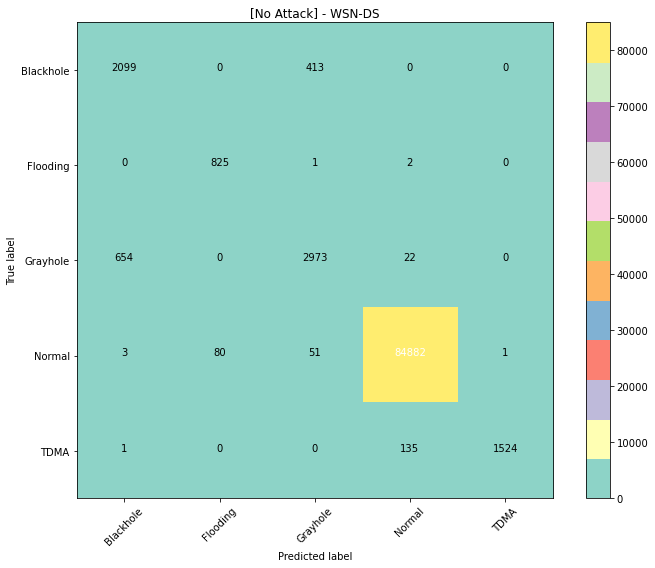

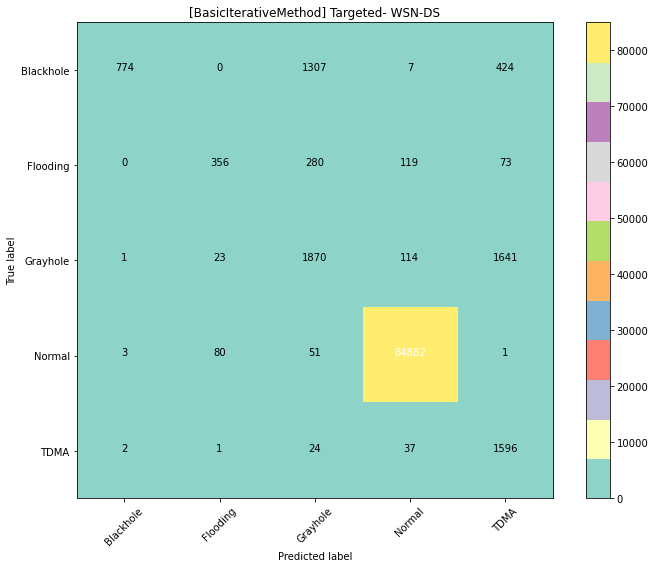

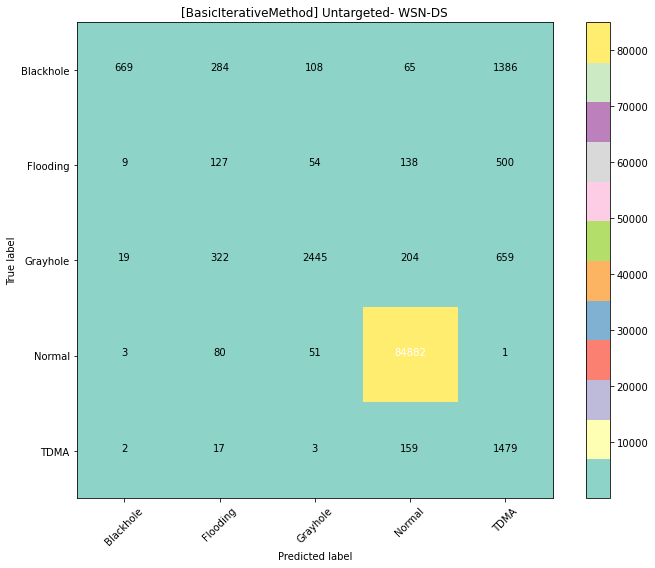

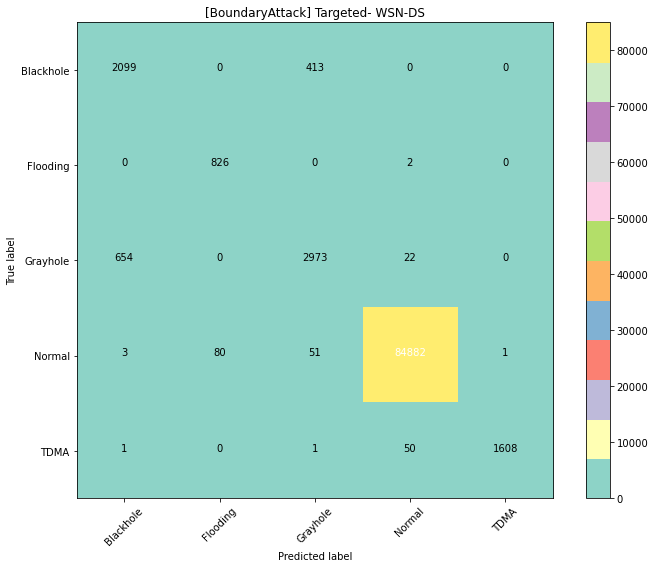

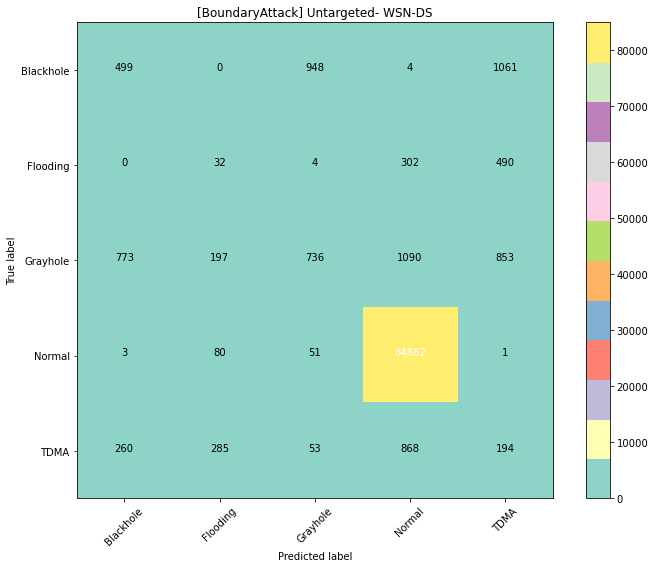

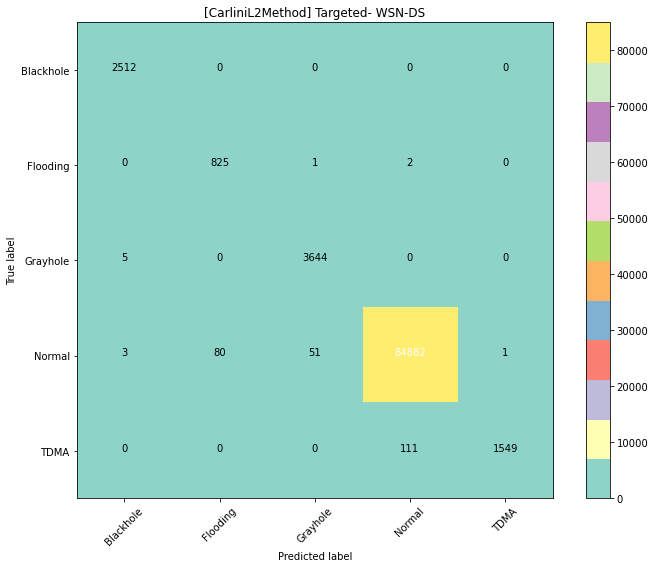

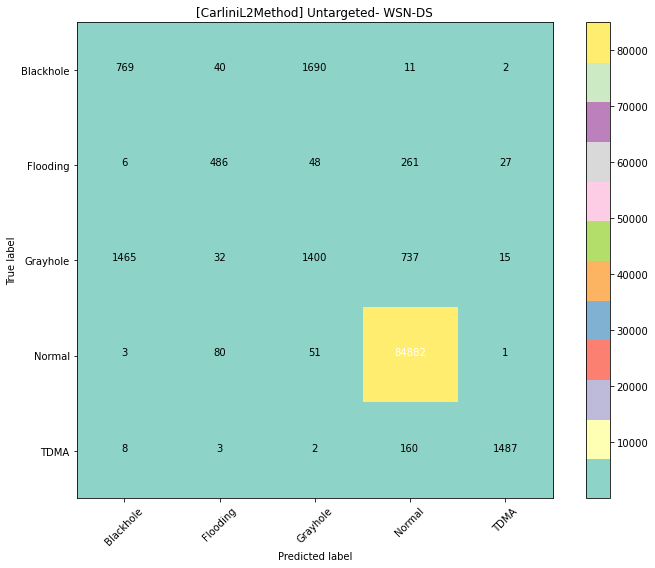

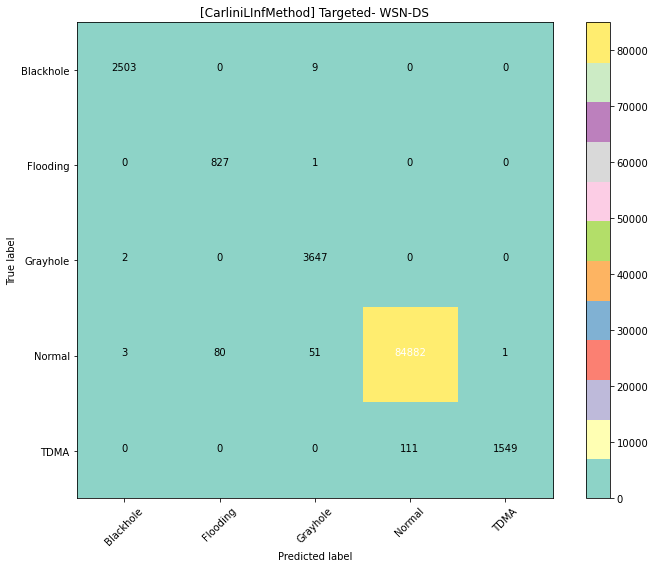

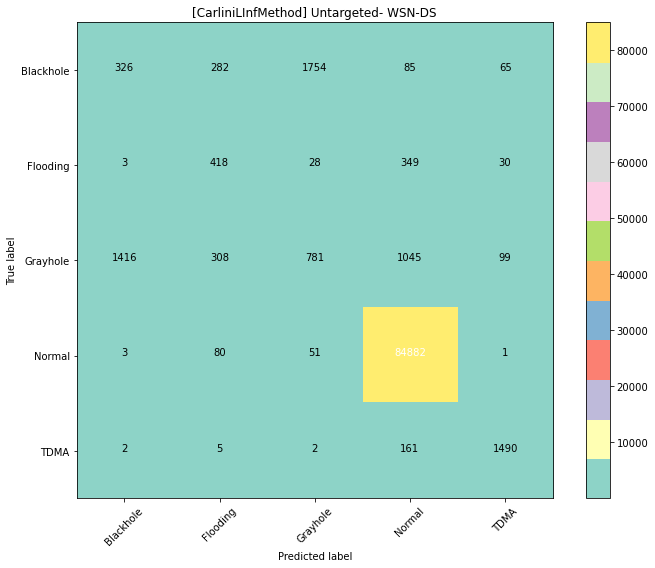

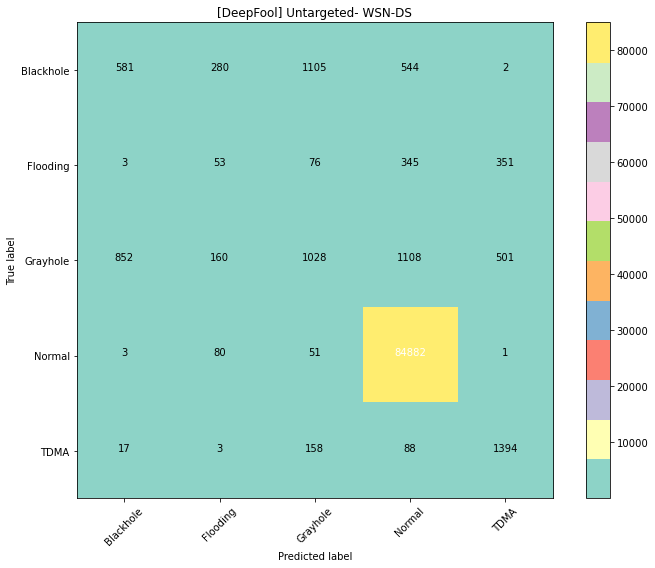

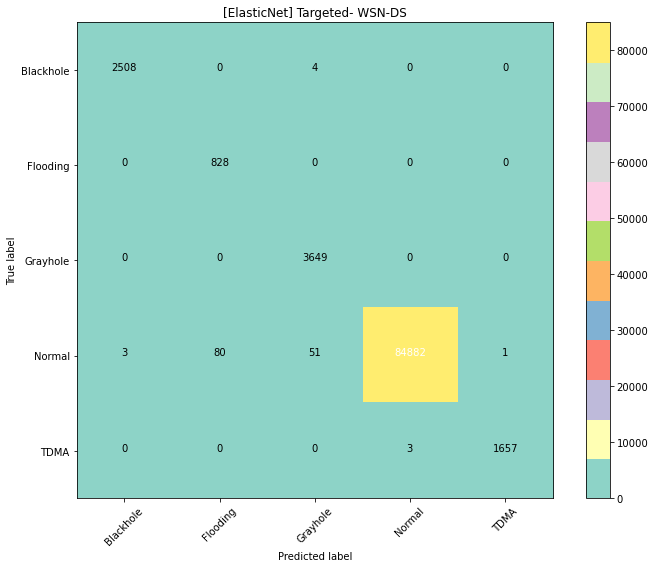

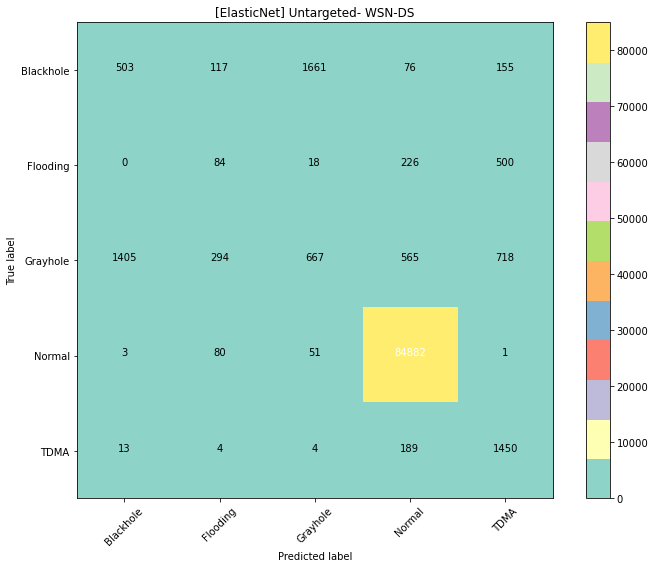

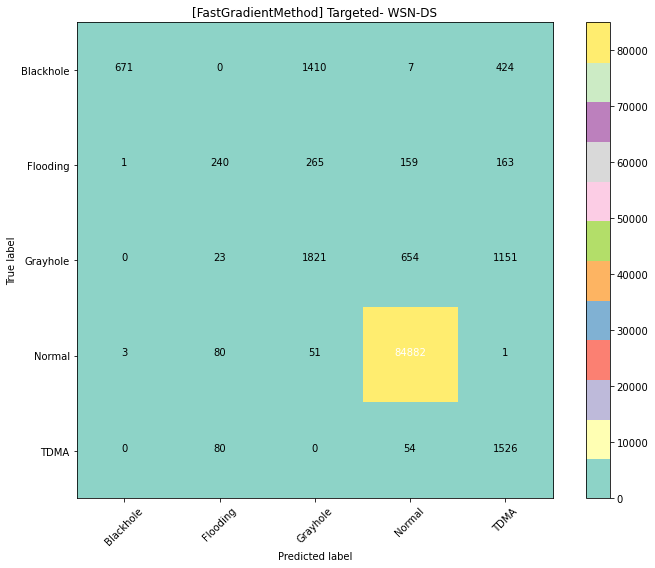

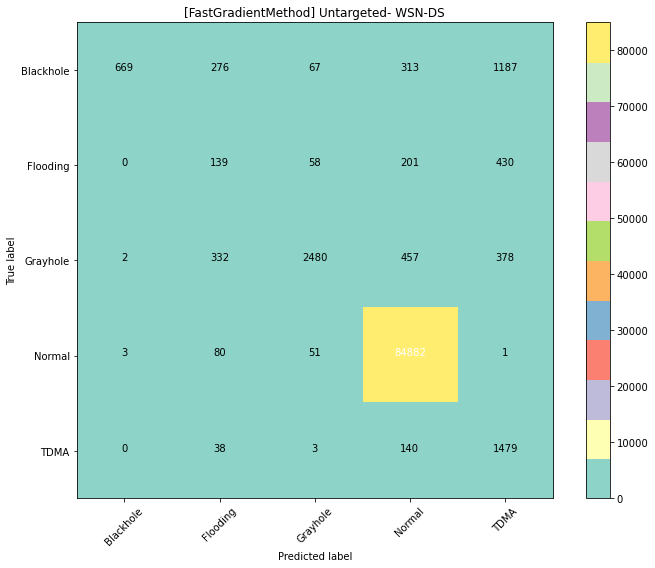

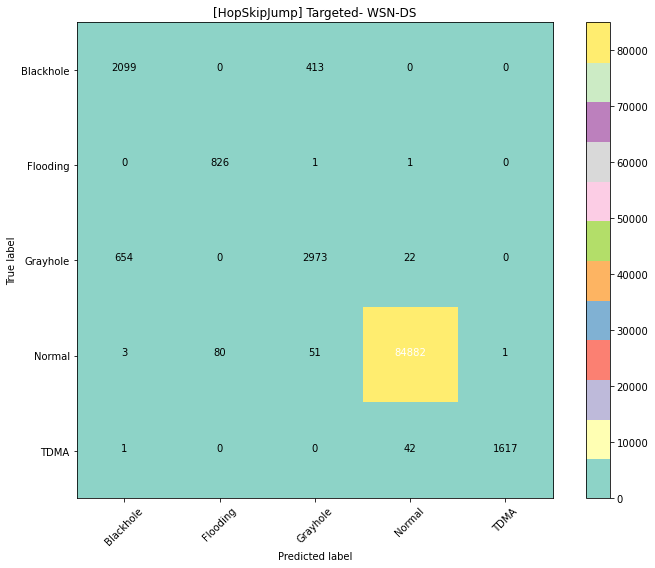

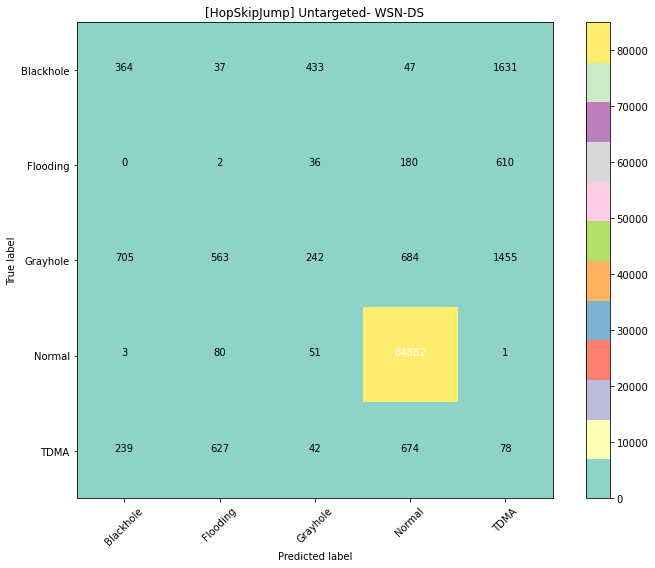

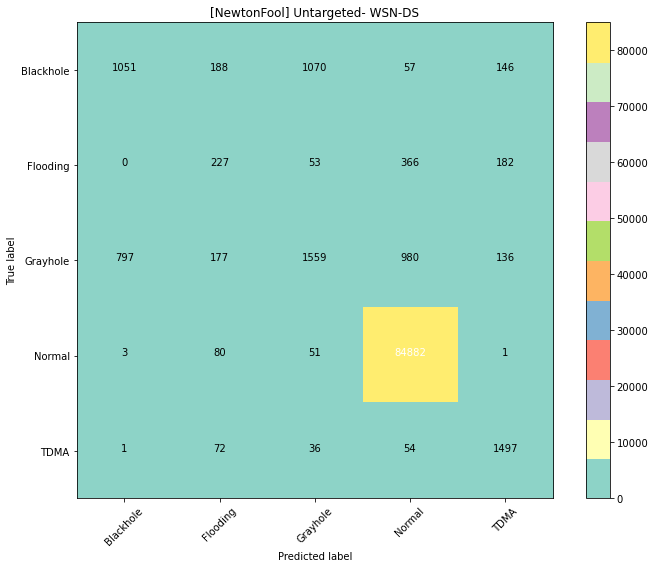

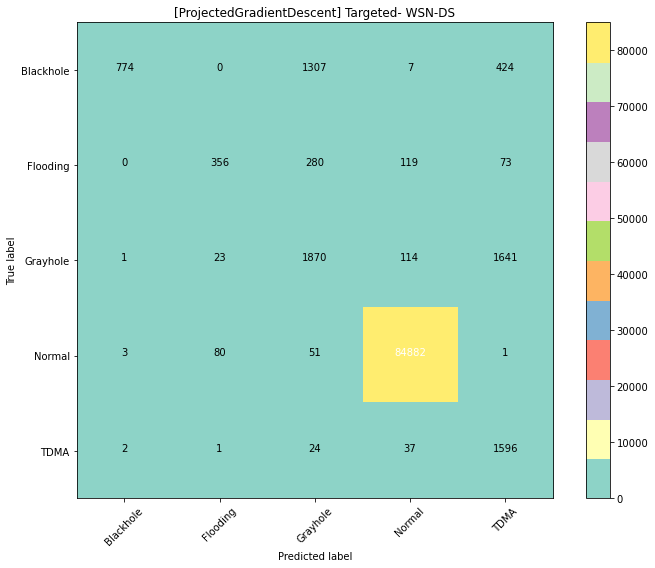

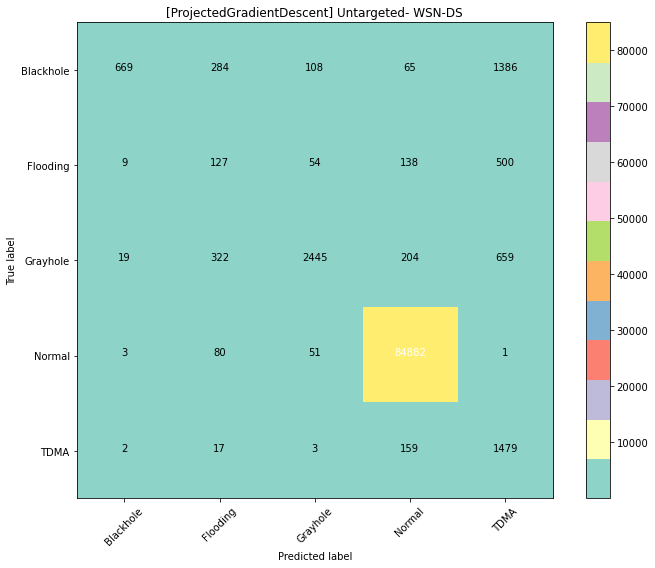

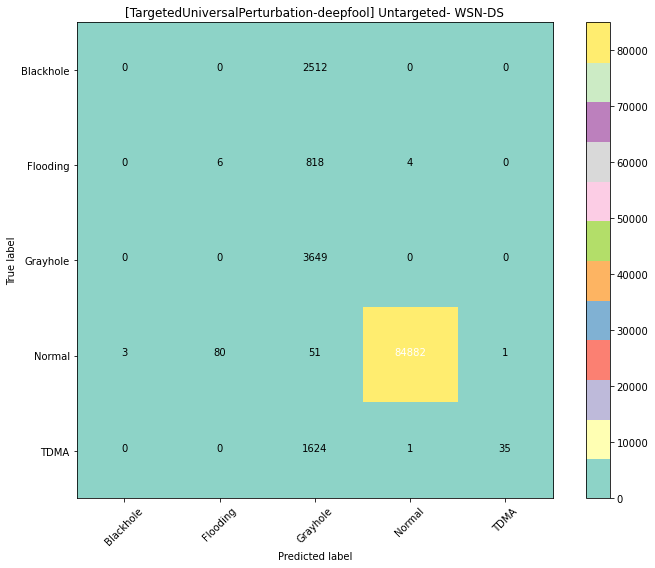

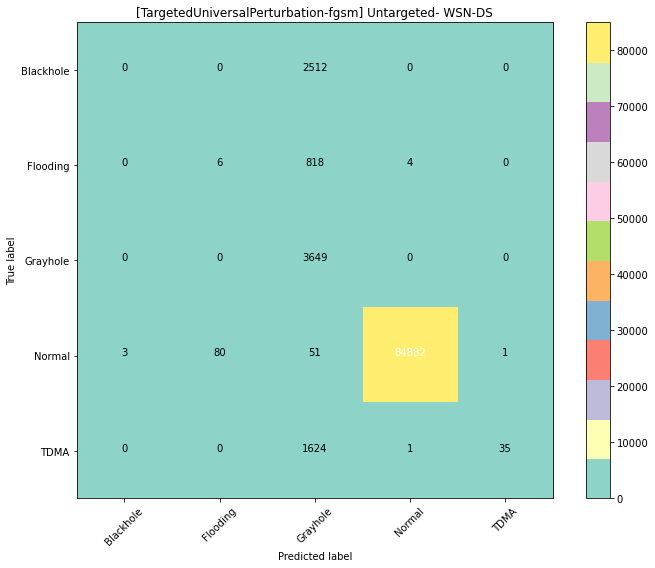

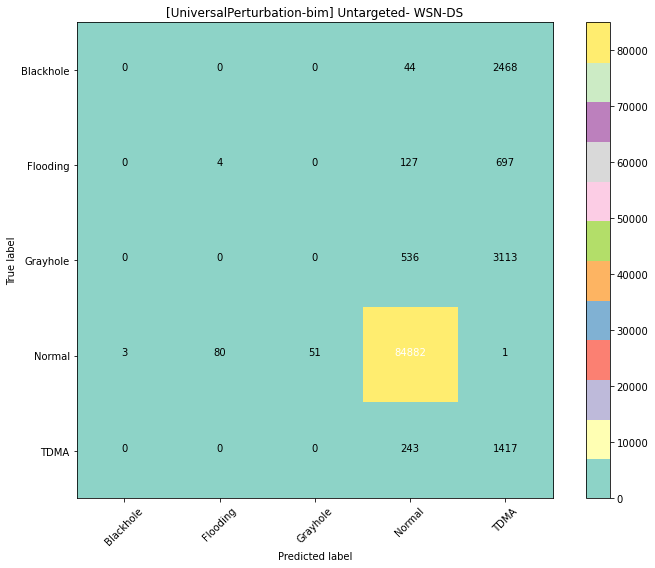

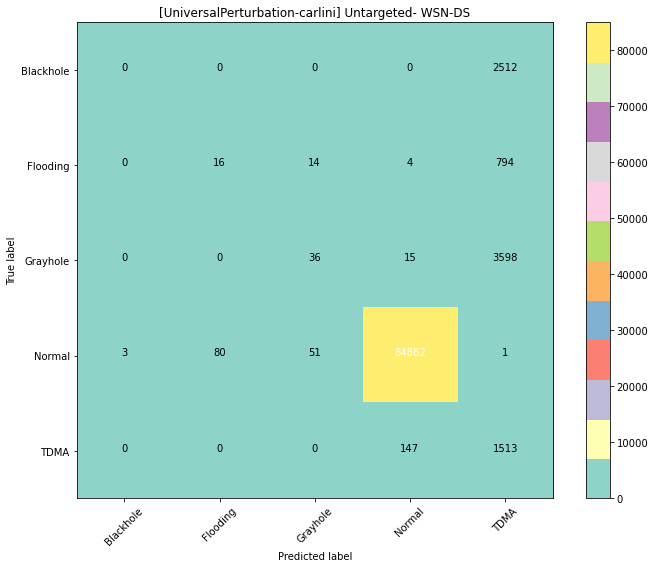

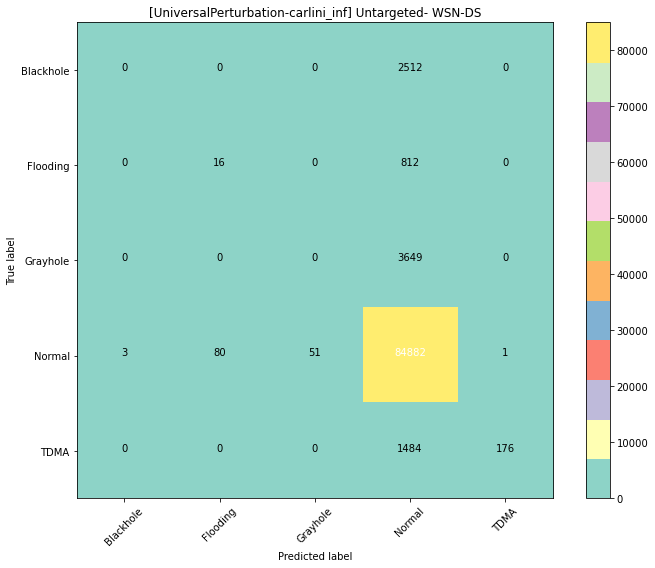

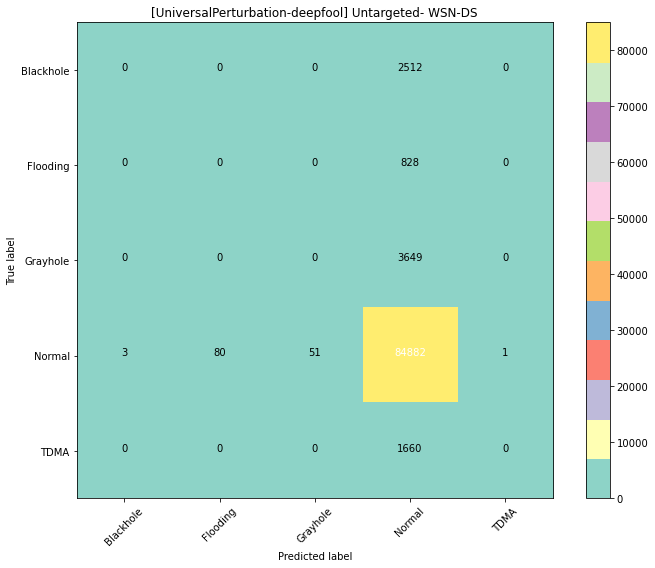

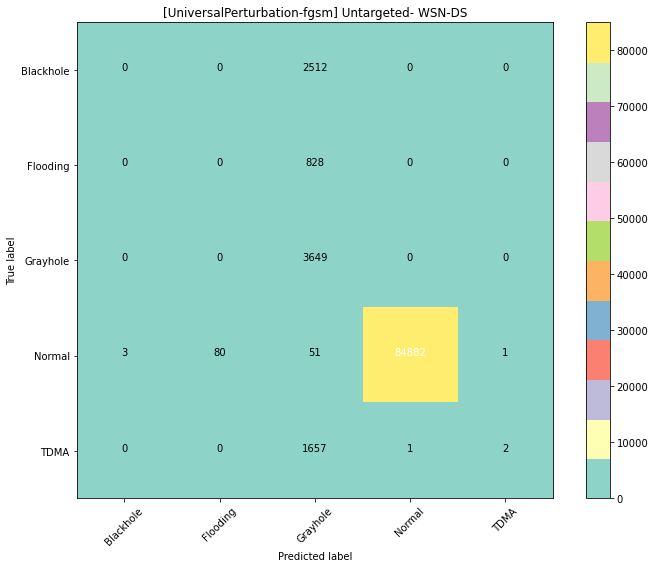

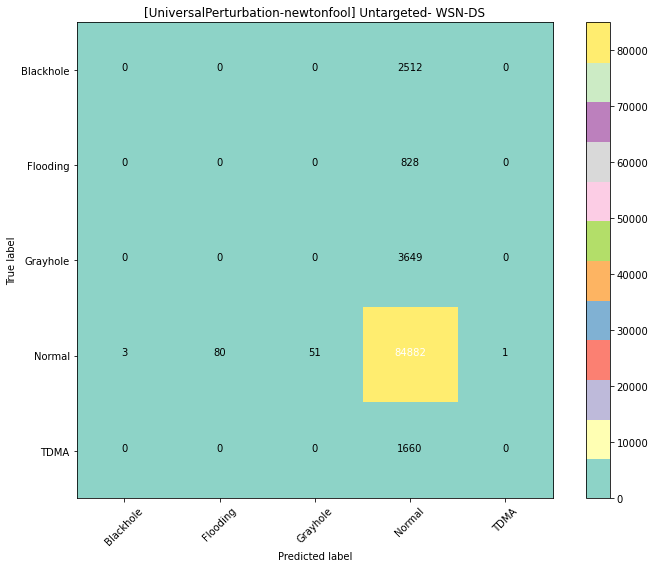

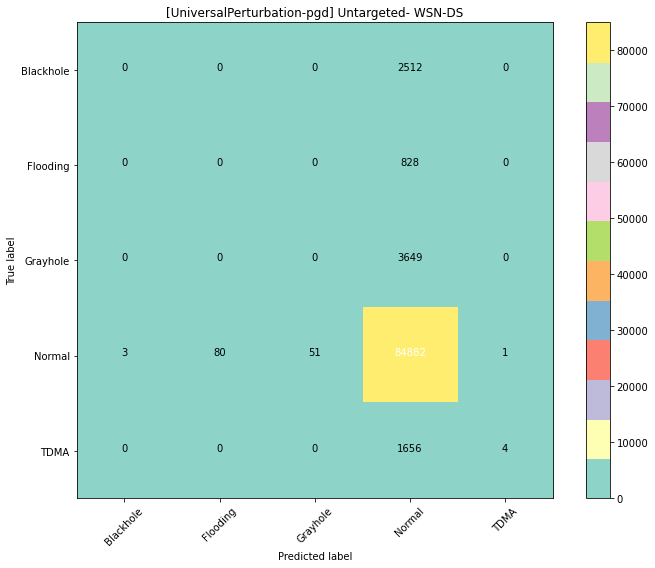

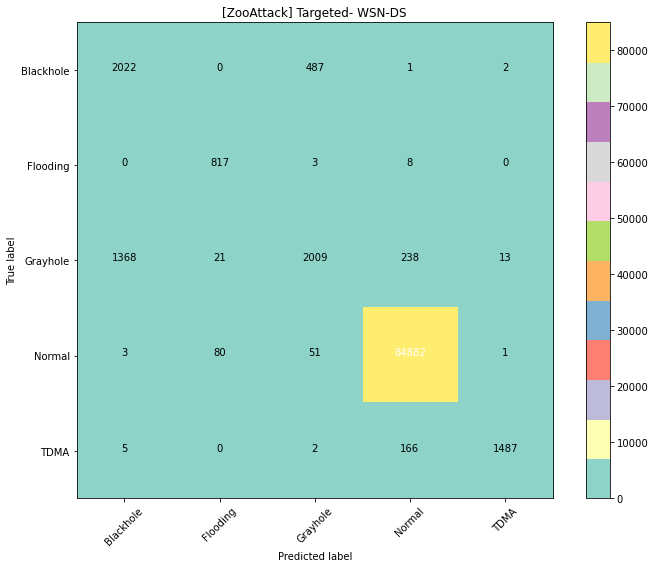

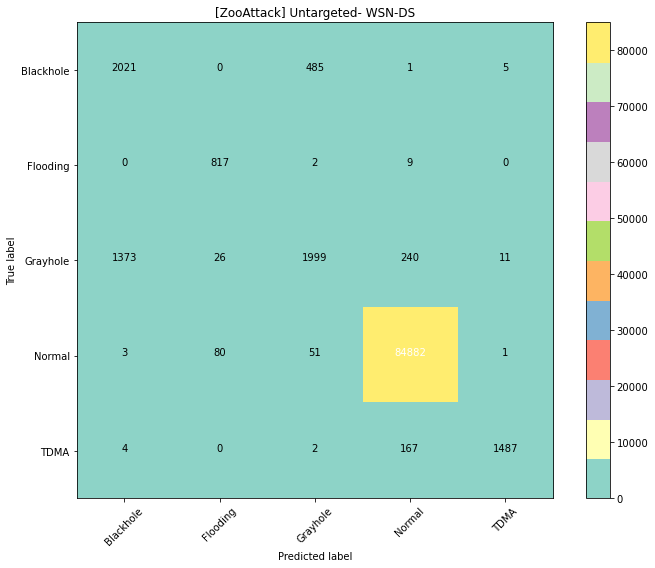

In [5]:
evaluate(KerasClassifier_to_attack,'', 'No Attack','NA', 'WSN-DS', 'NA')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/BasicIterativeMethod[Targeted]X-test.csv",'BasicIterativeMethod',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/BasicIterativeMethod[Untargeted]X-test.csv",'BasicIterativeMethod',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/BoundaryAttack[Targeted]X-test.csv",'BoundaryAttack',True,'WSN-DS','Black-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/BoundaryAttack[Untargeted]X-test.csv",'BoundaryAttack',False,'WSN-DS','Black-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/CarliniL2Method[Targeted]X-test.csv",'CarliniL2Method',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/CarliniL2Method[Untargeted]X-test.csv",'CarliniL2Method',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/CarliniLInfMethod[Targeted]X-test.csv",'CarliniLInfMethod',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/CarliniLInfMethod[Untargeted]X-test.csv",'CarliniLInfMethod',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/DeepFool[Untargeted]X-test.csv",'DeepFool',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ElasticNet[Targeted]X-test.csv",'ElasticNet',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ElasticNet[Untargeted]X-test.csv",'ElasticNet',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/FastGradientMethod[Targeted]X-test.csv",'FastGradientMethod',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/FastGradientMethod[Untargeted]X-test.csv",'FastGradientMethod',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/HopSkipJump[Targeted]X-test.csv",'HopSkipJump',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/HopSkipJump[Untargeted]X-test.csv",'HopSkipJump',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/NewtonFool[Untargeted]X-test.csv",'NewtonFool',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ProjectedGradientDescent[Targeted]X-test.csv",'ProjectedGradientDescent',True,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ProjectedGradientDescent[Untargeted]X-test.csv",'ProjectedGradientDescent',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/TargetedUniversalPerturbation-deepfool[Untargeted]X-test.csv",'TargetedUniversalPerturbation-deepfool',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/TargetedUniversalPerturbation-fgsm[Untargeted]X-test.csv",'TargetedUniversalPerturbation-fgsm',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-bim[Untargeted]X-test.csv",'UniversalPerturbation-bim',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-carlini[Untargeted]X-test.csv",'UniversalPerturbation-carlini',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-carlini_inf[Untargeted]X-test.csv",'UniversalPerturbation-carlini_inf',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-deepfool[Untargeted]X-test.csv",'UniversalPerturbation-deepfool',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-fgsm[Untargeted]X-test.csv",'UniversalPerturbation-fgsm',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-newtonfool[Untargeted]X-test.csv",'UniversalPerturbation-newtonfool',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/UniversalPerturbation-pgd[Untargeted]X-test.csv",'UniversalPerturbation-pgd',False,'WSN-DS','White-box')
#evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/VirtualAdversarialMethod[Untargeted]X-test.csv",'VirtualAdversarialMethod',False,'WSN-DS','White-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ZooAttack[Targeted]X-test.csv",'ZooAttack',True,'WSN-DS','Black-box')
evaluate(KerasClassifier_to_attack,"Output/Crafted Testing Data/WSN-DS/ZooAttack[Untargeted]X-test.csv",'ZooAttack',False,'WSN-DS','Black-box')